# Homography

In [3]:
%pylab inline
from PIL import Image
from skimage.transform import warp, ProjectiveTransform
set_printoptions(precision=4, linewidth=120)

Populating the interactive namespace from numpy and matplotlib


We're going to use a homography to warp this image.

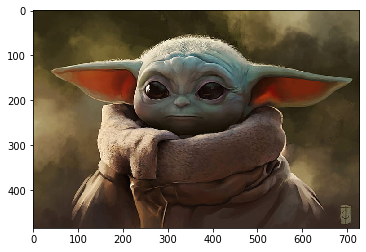

In [4]:
img = array(Image.open('baby-yoda.jpg'))
imshow(img)
height, width = img.shape[:2]

First, we will set up our point mappings. Remember, we need **four pairs** of points in order to find the eight parameters of the homography matrix, because each pair of points gives us two independent equations.

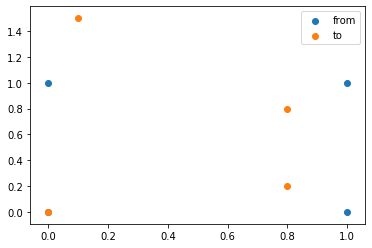

In [11]:
# the "from" points: the homography will warp these points to the "to" points
pf = array([[0, 0],
            [0, 1],
            [1, 1],
            [1, 0]])# * [width, height]
# the "to" points: the homography will warp the "from" points onto these points
pt = array([[ 0, 0.0],
            [.1, 1.5],
            [.8, 0.8],
            [.8, 0.2]])# * [width, height]
# show the two sets of points
scatter(pf[:,0], pf[:,1], label='from')
scatter(pt[:,0], pt[:,1], label='to')
legend()
pass

Now we set up and solve for the homography parameters using the "Four-Point Algorithm". Calling it an algorithm is a bit of a stretch: it's just solving a linear system using matrix inversion. This is the system we need to solve:

\begin{align}
\begin{bmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 & -x'_1x_1 & -x'_1y_1 \\
0 & 0 & 0 & x_1 & y_1 & 1 & -y'_1x_1 & -y'_1y_1 \\
x_2 & y_2 & 1 & 0 & 0 & 0 & -x'_2x_2 & -x'_2y_2 \\
0 & 0 & 0 & x_2 & y_2 & 1 & -y'_2x_2 & -y'_2y_2 \\
x_3 & y_3 & 1 & 0 & 0 & 0 & -x'_3x_3 & -x'_3y_3 \\
0 & 0 & 0 & x_3 & y_3 & 1 & -y'_3x_3 & -y'_3y_3 \\
x_4 & y_4 & 1 & 0 & 0 & 0 & -x'_4x_4 & -x'_4y_4 \\
0 & 0 & 0 & x_4 & y_4 & 1 & -y'_4x_4 & -y'_4y_4 \\
\end{bmatrix}
\begin{bmatrix}
h_{00} \\ h_{01} \\ h_{02} \\ h_{10} \\ h_{11} \\ h_{12} \\ h_{20} \\ h_{21}
\end{bmatrix} = 
\begin{bmatrix}
x'_1 \\ y'_1 \\ x'_2 \\ y'_2 \\ x'_3 \\ y'_3 \\ x'_4 \\ y'_4
\end{bmatrix}
\end{align}

The $x_i,y_i$ points are the "from" points, and the $x'_i,y'_i$ are the "to" points. The $h_{j,k}$ are the homography parameters that we are solving for.

In [13]:
# set up the matrix
A = np.zeros((8,8))
A[::2, :2] = pf
A[::2, 2] = 1
A[1::2, 5] = 1
A[1::2, 3:5] = pf
A[::2, -2:] = -pt[:,0:1] * pf
A[1::2, -2:] = -pt[:,1:] * pf
# solve for the h values by matrix inversion
H = pinv(A) @ pt.flatten()
# create the homography matrix from the h values
H = concatenate((H, [1])).reshape(3,3)
A
print(H)

[[ 2.1333e+00  1.1429e-01 -8.7146e-18]
 [ 5.3333e-01  1.7143e+00 -1.8548e-15]
 [ 1.6667e+00  1.4286e-01  1.0000e+00]]


Once we have the homography matrix, we can use it to map the "from" points to the "to" points. Remember to normalize the result back to homogenous coordinates:
\begin{align}
\begin{bmatrix}h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12} \\ h_{20} & h_{21} & 1\end{bmatrix}
\begin{bmatrix}x\\y\\1\end{bmatrix} = 
\begin{bmatrix}x'\\y'\\z'\end{bmatrix}\ \longrightarrow\ \begin{bmatrix}x'/z'\\y'/z'\\1\end{bmatrix}
\end{align}

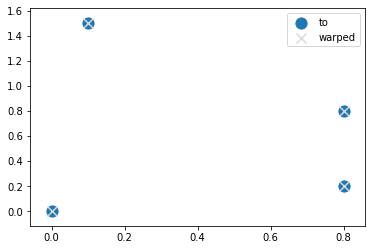

In [14]:
# convert the "from" points into homogenous coordinates
pf_h = concatenate((pf, ones((pf.shape[0], 1))), 1)
# warp the points through the homography transform
z = (H @ pf_h.T).T
# normalize by the last coordinate
z = z[:, :2] / z[:, -1:]
# show the warped points
scatter(pt[:,0], pt[:,1], marker='o', color='tab:blue', s=125, label='to')
scatter(z[:,0], z[:,1], marker='x', color=(.85,)*3, s=100, label='warped')
legend()
pass

Now we've verified it works! The great thing is that we can use the matrix we found to warp any points now. Let's try it out.

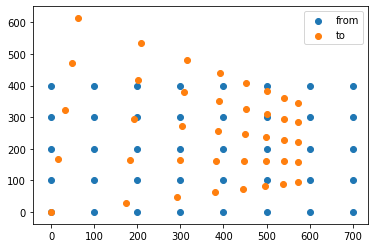

In [8]:
y, x = mgrid[:height+1:100, :width+1:100]
coords = stack((x.flatten(), y.flatten(), ones(x.size)), 1)
warped = (H @ coords.T)
warped = warped[:2] / warped[2]
warped

scatter(x, y, label='from')
scatter(warped[0], warped[1], label='to')
legend()
pass

We can also apply the transformation to an image. This time we use the inverse warping to find the pixel values in the original image that are closest to the values we want to warp to.

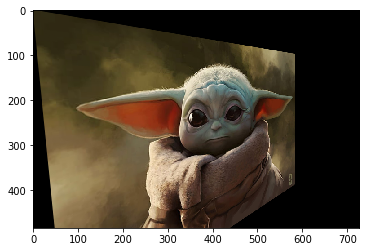

In [9]:
imshow(warp(img, pinv(H)))